In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
from rtlive.sources import ourworldindata, data_de, data_be

In [4]:
run_time = pandas.Timestamp.today()
owid_data = ourworldindata.download_owid(run_time)
data_be_data = data_be.get_data_BE(run_time)

E:\Anaconda3\envs\rtlive\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epistat.sciensano.be'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [5]:
df_be = data_be_data.copy()
df_owid_be = owid_data.xs('BE')
df_owid_be_total_tests = df_owid_be.xs('all').total_tests
df_owid_be_daily_tests = df_owid_be_total_tests.diff()

## Attempt to create the DataFrame as it would be created by the data_de source

In [6]:
#Create weekly data with NaN gaps as total_tests_reported column for the `all` region:
df_be_weekly_total_tests = df_owid_be_total_tests.resample('W-Sun', level='date').last() #XXX: I don't know if the german data reported for sunday does include the data for sunday itself.
df_be_weekly_total_tests.drop(df_be_weekly_total_tests.tail(1).index,inplace=True) #Remove last row, because its an incomplete week in the future
weekly_data_frame = df_be_weekly_total_tests.resample('1D').asfreq().rename('total_tests_reported').to_frame()
weekly_data_frame['region'] = 'all'
weekly_data_frame = weekly_data_frame.reset_index().set_index(['region', 'date'])

df_be_merged = df_be.assign(total_tests_reported=weekly_data_frame)
df_be_merged

new_cases  new_tests  total_tests_reported
region date                                                  
ANT    2020-03-01          0         18                   NaN
       2020-03-02          1         38                   NaN
       2020-03-03          1        112                   NaN
       2020-03-04          3        131                   NaN
       2020-03-05          9        118                   NaN
...                      ...        ...                   ...
all    2021-01-06       3298      55146                   NaN
       2021-01-07       2454      43992                   NaN
       2021-01-08       2212      45976                   NaN
       2021-01-09       1729      35811                   NaN
       2021-01-10         32        769                   NaN

[4424 rows x 3 columns]

Simulate the current data situation for germany: Daily data until approx. 2020-12-07, weekly data until 2020-12-27

In [7]:
end_of_daily_data = pandas.Timestamp('2020-12-07')
end_of_weekly_data = pandas.Timestamp('2020-12-27') + pandas.Timedelta('1D')

In [8]:
df_be_merged.loc[(slice(None), slice(end_of_daily_data,None)), 'new_tests'] = numpy.nan
df_be_merged.loc[(slice(None), slice(end_of_weekly_data,None)), 'total_tests_reported'] = numpy.nan

## Call the original forecast method

In [9]:
df_forecast, results = data_be.forecast_BE(df_be_merged) #Using DE forecast, because BE didn't work?

INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for ANT from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for WBR from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for BRU from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for FLA from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for HAI from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LIM from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LIE from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LUX from 281 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testc

(18589.0, 18652.75)

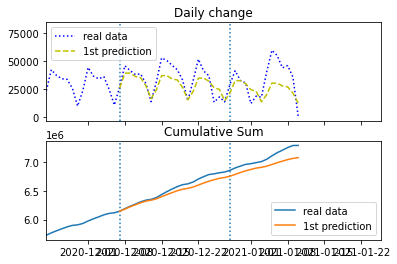

In [10]:
plotstart = end_of_daily_data - pandas.Timedelta('2W')
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(data_be_data.loc['all']['new_tests'], 'b:', label="real data")
axs[0].plot(df_forecast.loc['all']['predicted_new_tests'][end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(data_be_data.loc['all']['new_tests'].cumsum()[plotstart:],label="real data")
axs[1].plot(df_forecast.loc['all']['predicted_new_tests'].cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].legend()
pyplot.xlim(plotstart)

## Call scaling method of `data_de` source

In [11]:
corrected_prediction = data_de.scale_forecast_by_total_tests_reported(df_forecast.loc['all', 'new_tests'], df_forecast.loc['all', 'total_tests_reported'], df_forecast.loc['all', 'predicted_new_tests'])
df_forecast.loc['all', 'corrected_prediction'] = corrected_prediction

(18589.0, 18652.75)

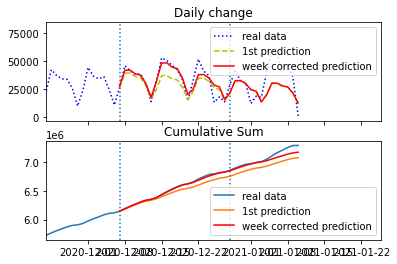

In [12]:
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(data_be_data.loc['all']['new_tests'], 'b:', label="real data")
axs[0].plot(df_forecast.loc['all']['predicted_new_tests'][end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].plot(corrected_prediction[end_of_daily_data:], "r-", label="week corrected prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(data_be_data.loc['all']['new_tests'].cumsum()[plotstart:],label="real data")
axs[1].plot(df_forecast.loc['all']['predicted_new_tests'].cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].plot(corrected_prediction.cumsum()[end_of_daily_data:], "r-", label="week corrected prediction")
axs[1].legend()
pyplot.xlim(plotstart)

## Overwrite predicted test result

In [13]:
#df_forecast.loc['all', 'predicted_new_tests'] = corrected_prediction

## Apply the same scaling to the other regions for which we don't have data.

This assumes that the Prediction error for the all region is similar/the same as it is for the other regions.

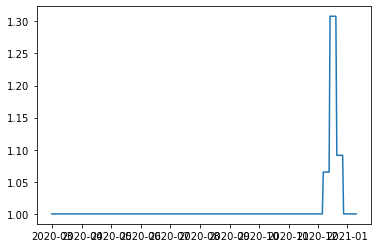

In [14]:
factor = corrected_prediction/df_forecast.loc['all', 'predicted_new_tests']
pyplot.plot(factor)

In [15]:
def plot_corrected(region, corrected, corrected2=None, region_report = None):
    fig, (axs,axs2) = pyplot.subplots(2,2,sharex=True,figsize=(9,6), dpi= 100)
    axs[0].axvline(end_of_daily_data,linestyle="dotted")
    axs[0].axvline(end_of_weekly_data,linestyle="dotted")
    axs[0].set_title("Daily change " + region)
    axs[0].plot(df_forecast.loc[region]['predicted_new_tests'][end_of_daily_data:], "y--",  label = "1st prediction")
    axs[0].plot(corrected[end_of_daily_data:], "r-", label="week corrected prediction")
    if corrected2 is not None:
        axs[0].plot(corrected2[end_of_daily_data:], "k-", label="week corrected prediction 2")
    axs[0].plot(data_be_data.loc[region, 'new_tests'], 'b:', label="real data")
    #axs[0].legend()
    axs[1].set_title("Cumulative Sum " + region)
    axs[1].axvline(end_of_daily_data,linestyle="dotted")
    axs[1].axvline(end_of_weekly_data,linestyle="dotted")
    axs[1].plot(df_forecast.loc[region]['predicted_new_tests'].cumsum()[end_of_daily_data:], label = "1st prediction")
    axs[1].plot(corrected.cumsum()[end_of_daily_data:], "r-", label="week corrected prediction")
    if corrected2 is not None:
        axs[1].plot(corrected2.cumsum()[end_of_daily_data:], "k-", label="week corrected prediction")
    if region_report is not None:
        axs[1].plot(region_report, "y+", label="predicted region report")
    axs[1].plot(data_be_data.loc[region]['new_tests'].cumsum()[plotstart:],'b:', label="real data")
    #axs[1].legend()
    axs2[0].set_title("Absolue difference to real data" + region)
    axs2[0].axvline(end_of_daily_data,linestyle="dotted")
    axs2[0].axvline(end_of_weekly_data,linestyle="dotted")
    axs2[0].plot(numpy.abs(data_be_data.loc[region, 'new_tests'] - df_forecast.loc[region]['predicted_new_tests']), "y--",  label = "1st prediction")
    axs2[0].plot(numpy.abs(data_be_data.loc[region, 'new_tests'] - corrected), "r-", label="week corrected prediction")
    if corrected2 is not None:
        axs2[0].plot(numpy.abs(data_be_data.loc[region, 'new_tests'] - corrected2), "k-", label="week corrected prediction")
    
    axs2[1].set_title("Absolue difference to real data" + region)
    axs2[1].axvline(end_of_daily_data,linestyle="dotted")
    axs2[1].axvline(end_of_weekly_data,linestyle="dotted")
    axs2[1].plot(numpy.abs(data_be_data.loc[region, 'new_tests'].cumsum() - df_forecast.loc[region]['predicted_new_tests'].cumsum()), "y--",  label = "1st prediction")
    axs2[1].plot(numpy.abs(data_be_data.loc[region, 'new_tests'].cumsum() - corrected.cumsum()), "r-", label="week corrected prediction")
    if corrected2 is not None:
        axs2[1].plot(numpy.abs(data_be_data.loc[region, 'new_tests'].cumsum() - corrected2.cumsum()), "k-", label="week corrected prediction")
    if region_report is not None:
        axs2[1].plot(numpy.abs(data_be_data.loc[region, 'new_tests'].cumsum() - region_report), "y+", label="predicted region report")
    #axs[2].set_ylim(-3,3)
    pyplot.xlim(plotstart)

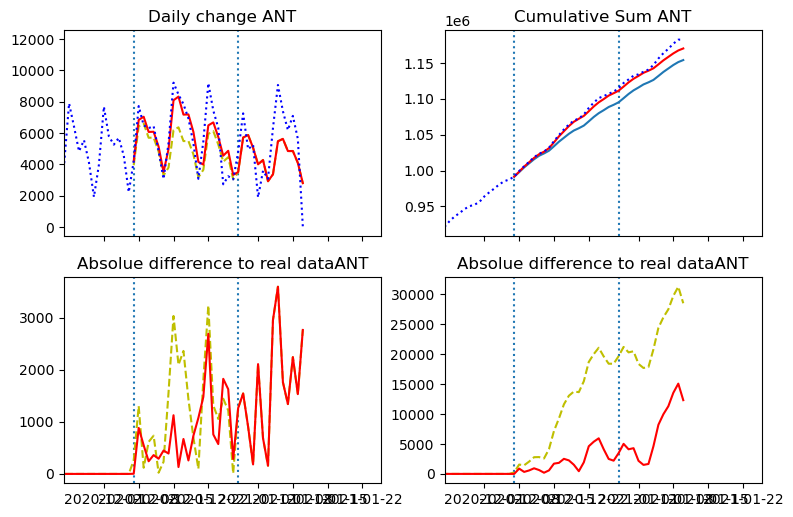

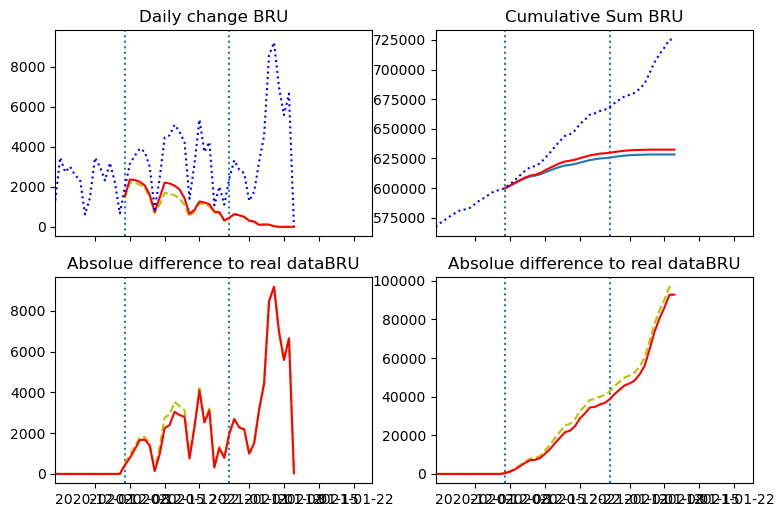

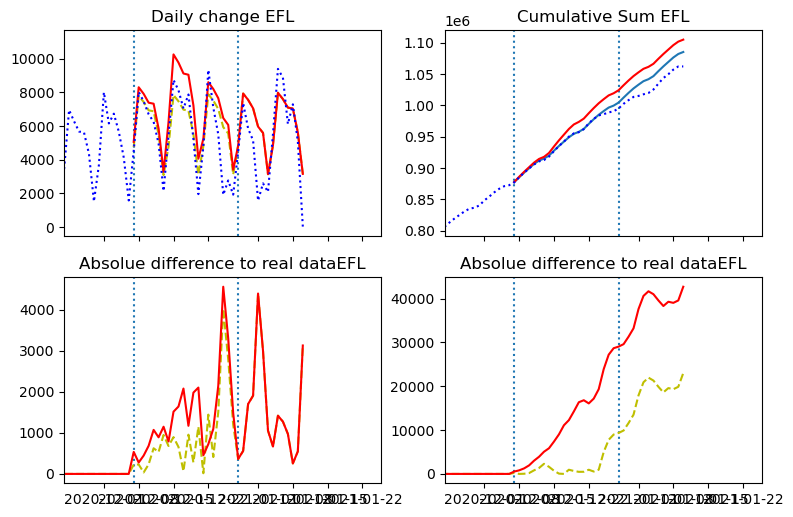

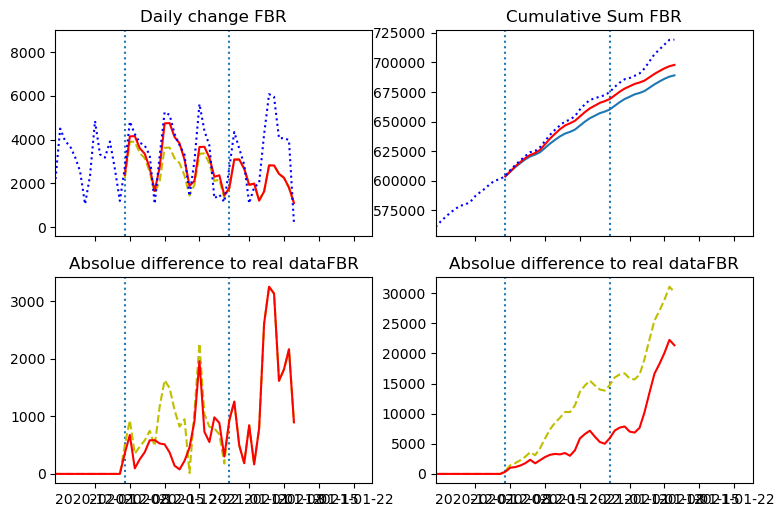

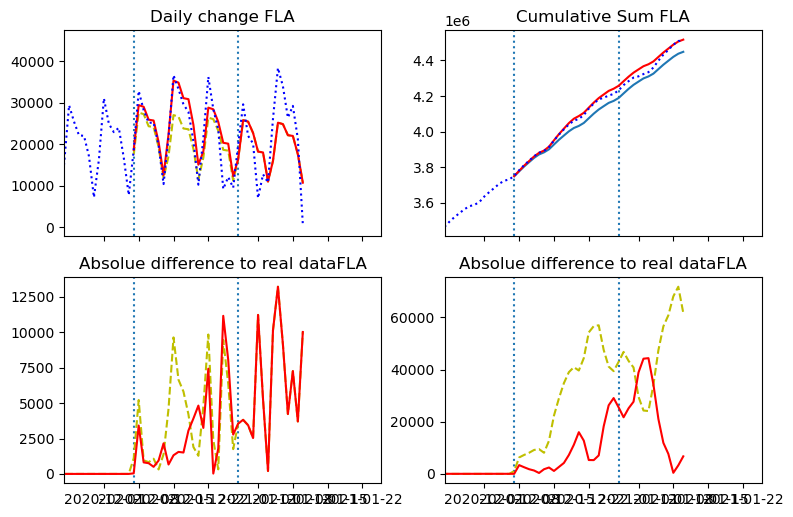

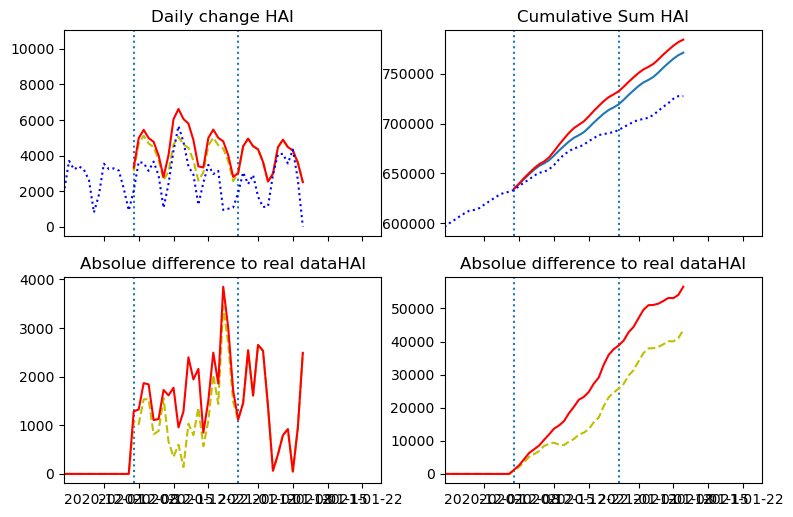

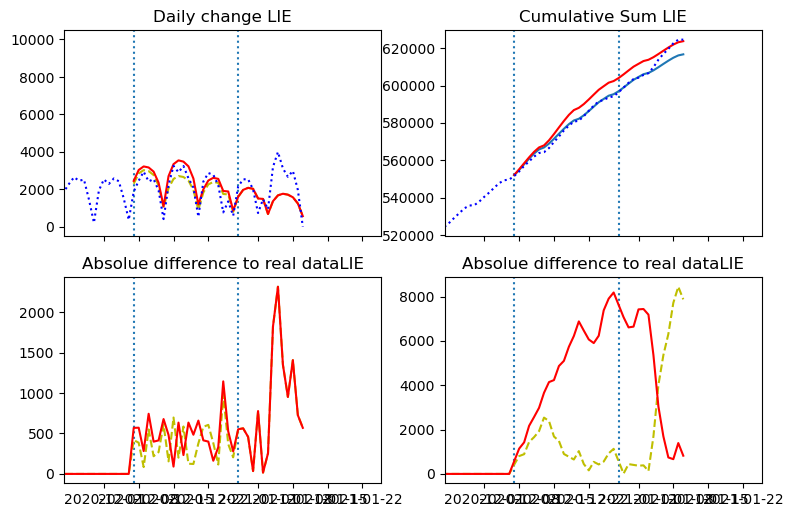

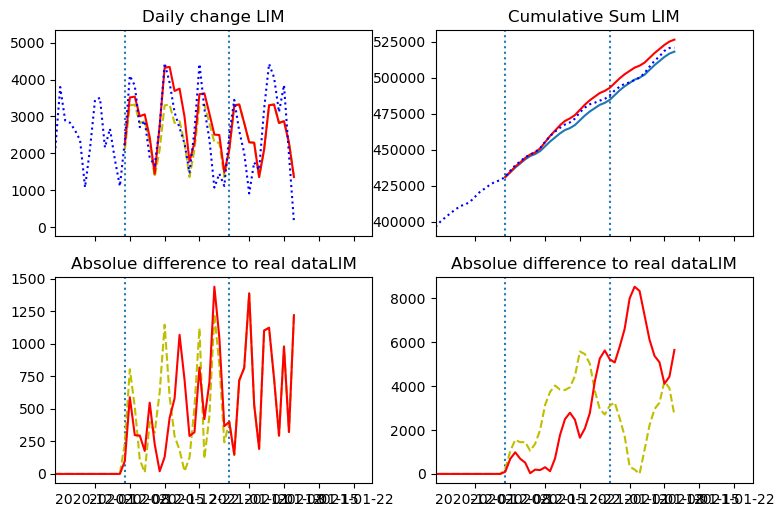

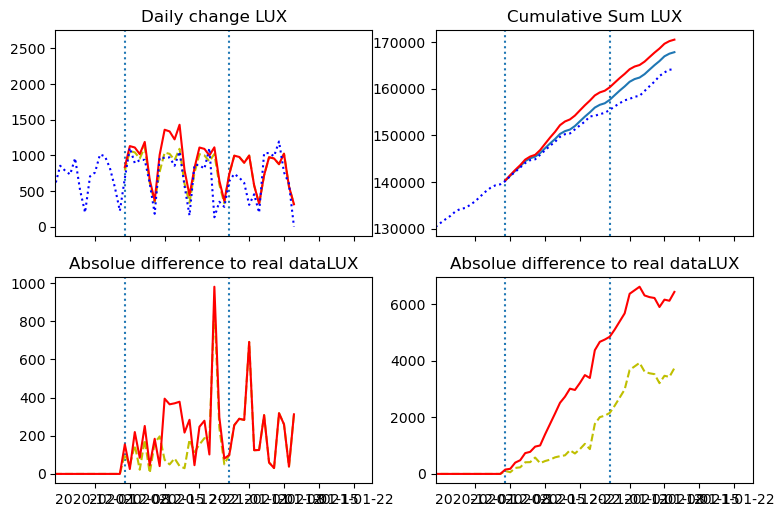

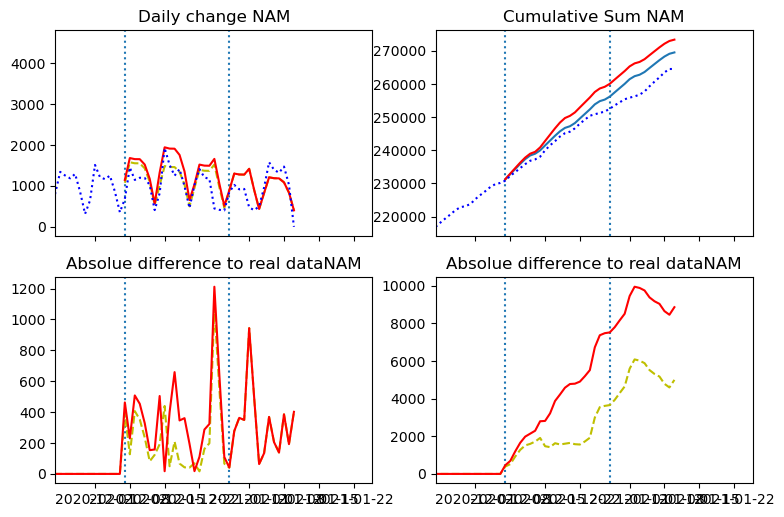

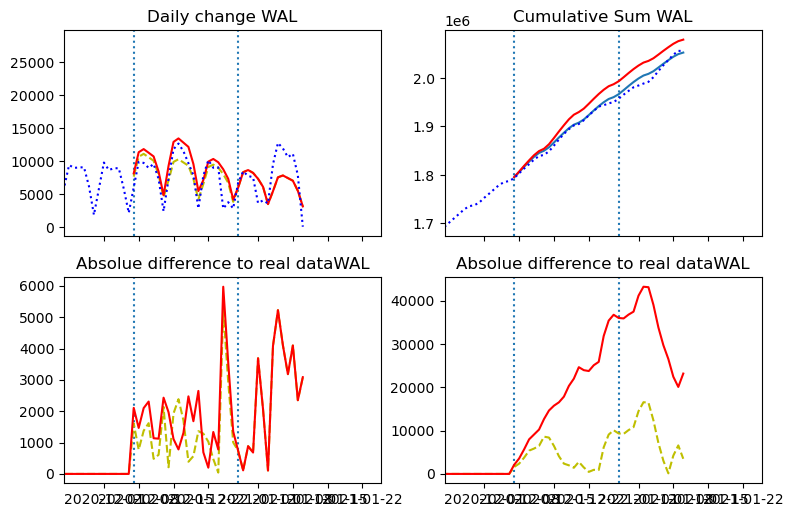

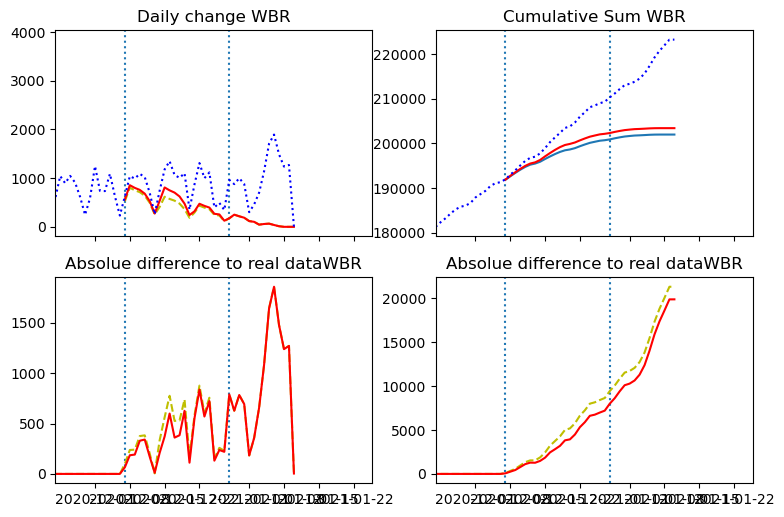

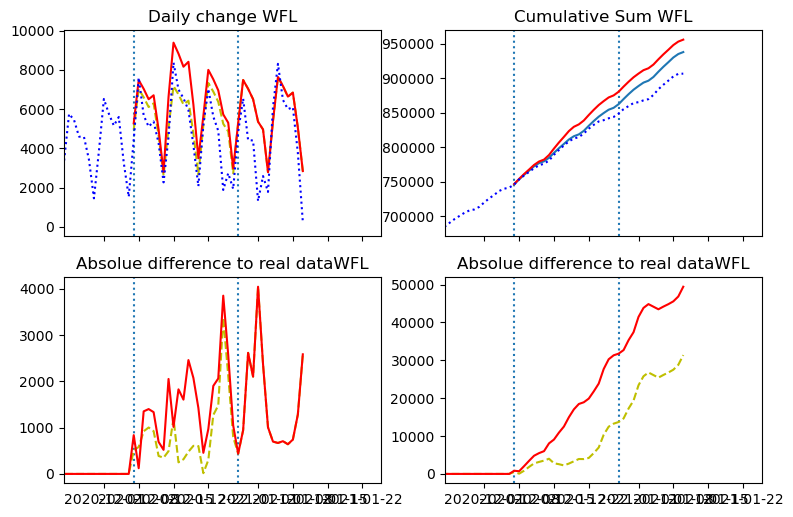

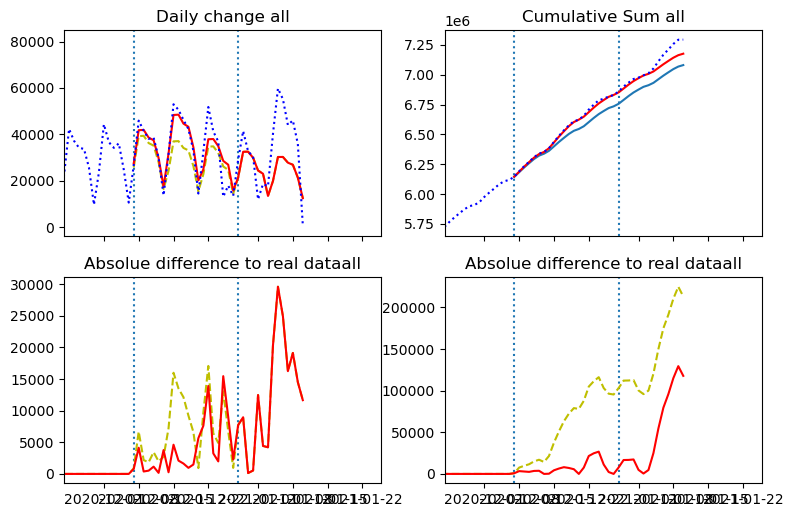

In [16]:
corrected_for = {}
for region in df_forecast.index.levels[0]:
    corrected = (df_forecast.loc[region]['predicted_new_tests'] * factor)
    corrected_for[region] = corrected
    plot_corrected(region, corrected)

This seems to only have worked for bigger regions like ANT, FBR, FLA, LIM, WAL

## Attempt to estimate the reports for the other regions based on previous tests

We take the last week of known daily data for all regions and calculate the percentages of tests in each region

In [17]:
# Find the last date for each region for which we have data and get the first date of those. So a date for which he have date for all regions.
last_date_with_data_for_all_regions = df_forecast.new_tests[~df_forecast.new_tests.isna()].groupby('region').tail(1).reset_index()['date'].min()
last_date_with_data_for_all_regions

Timestamp('2020-12-06 00:00:00')

In [18]:
non_all_regions = df_forecast.index.levels[0][df_forecast.index.levels[0] != 'all']
non_all_regions

Index(['ANT', 'BRU', 'EFL', 'FBR', 'FLA', 'HAI', 'LIE', 'LIM', 'LUX', 'NAM',
       'WAL', 'WBR', 'WFL'],
      dtype='object', name='region')

Calculate the sum of daily tests in the last week of known data:

In [19]:
testcounts_in_last_daily_data = df_forecast.new_tests.xs(slice(last_date_with_data_for_all_regions - pandas.Timedelta('6D'), last_date_with_data_for_all_regions),level='date').groupby('region').sum()
testcounts_in_last_daily_data

region
ANT     35218.0
BRU     16326.0
EFL     35959.0
FBR     21452.0
FLA    143612.0
HAI     18112.0
LIE     13684.0
LIM     16848.0
LUX      5071.0
NAM      7001.0
WAL     49978.0
WBR      5260.0
WFL     31675.0
all    209931.0
Name: new_tests, dtype: float64

So we estimate the tests in a region with the percentage of tests in a region multiplied by the growth of tests in the `all` region.
We then use the cumulative sum of tests in a region as a starting point for that estimated growth.

~~**This only works, if the source of the report-data and daily data match up!**~~ This is only true for plotting the estimated region count reports below. The correction does not need this.

**UPDATE:** The "complicated" algorithm to determine the `region_report` is only needed to plot the estimation against the real data (maybe not even that). For the correction we can just use `region_factor * all_reports`.

In [20]:
first_date_without_data_for_all_regions = last_date_with_data_for_all_regions + pandas.Timedelta('1D')
all_reports = df_forecast.loc['all', 'total_tests_reported'][~df_forecast.loc['all', 'total_tests_reported'].isna()]
report_index = all_reports.index.get_loc(first_date_without_data_for_all_regions,method="ffill")
reports_start_date = all_reports.index[report_index]
all_region_report = all_reports[reports_start_date:].diff()

region_report_for = {}

for region in df_forecast.index.levels[0]:
    region_factor = testcounts_in_last_daily_data[region] / testcounts_in_last_daily_data['all']
    #Find all the reports that are after the last known date and calculate weekly differences.
    
    #scale differences with region factor
    region_report = region_factor * all_region_report
    #set the first date to the cumulative sum from daily data #XXX: Assumption: cumulative sum of daily data has to match the report data!!!
    region_report.iloc[0] = df_forecast.loc[region, 'new_tests'][:reports_start_date].sum()
    #transfer back into cumulative sum
    region_report = region_report.cumsum()
    region_report_for[region] = region_report
    

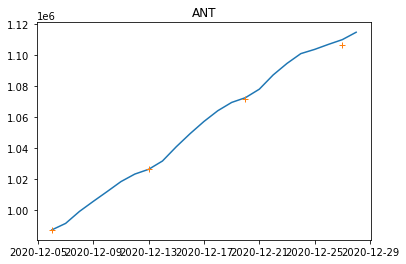

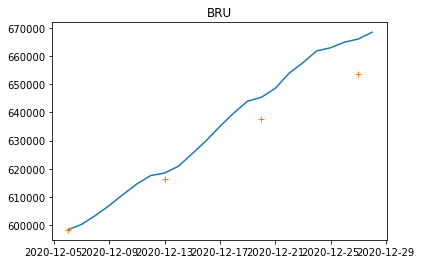

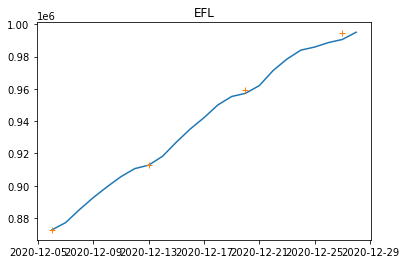

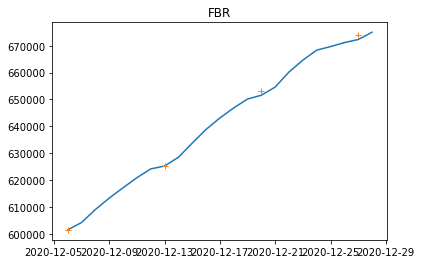

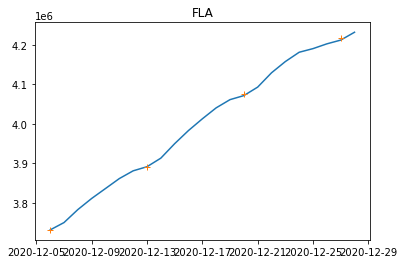

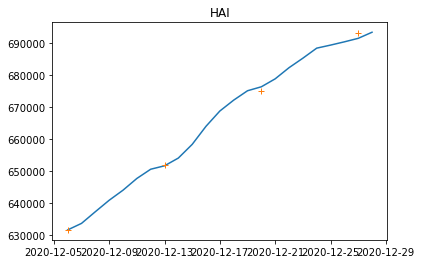

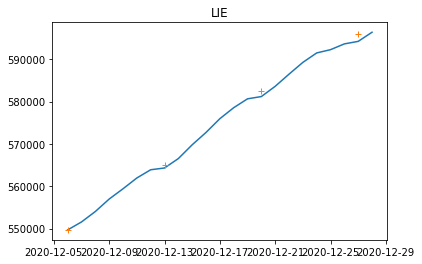

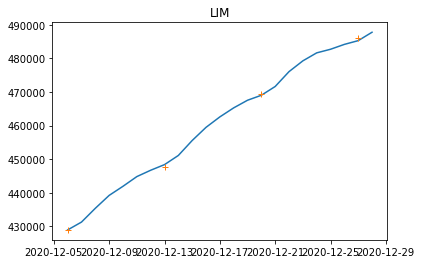

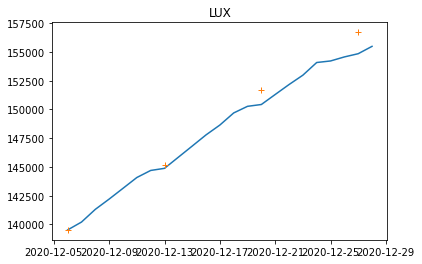

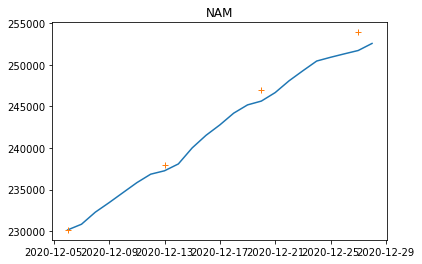

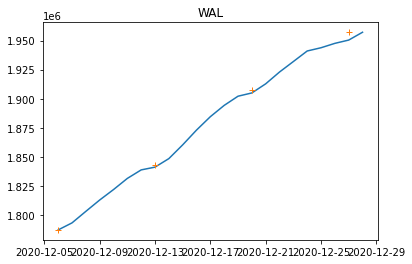

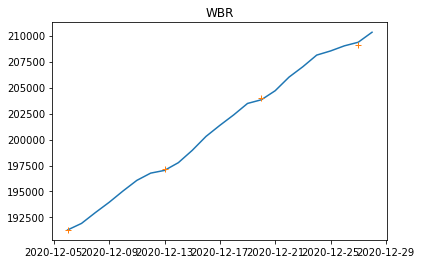

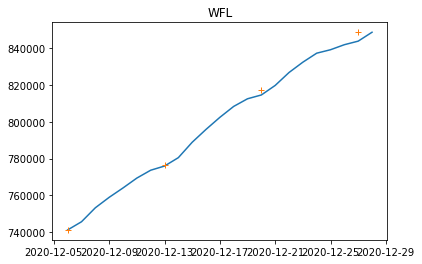

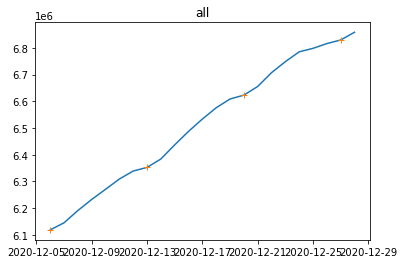

In [21]:
for region in df_forecast.index.levels[0]:
    fig, axs = pyplot.subplots(1)
    axs.set_title(region)
    axs.plot(data_be_data.loc[region, 'new_tests'].cumsum()[slice(reports_start_date,end_of_weekly_data)], '-')
    axs.plot(region_report_for[region], '+')

In [26]:
corrected_for2 = {}

for region in non_all_regions:
    corrected = data_de.scale_forecast_by_total_tests_reported(
        df_forecast.loc[region, 'new_tests'],
        #region_report_for[region], # We don't need this complicated calculated region report. We get the same result by using 
        all_reports * testcounts_in_last_daily_data[region] / testcounts_in_last_daily_data['all'],
        df_forecast.loc[region, 'predicted_new_tests'])
    corrected_for2[region] = corrected
 

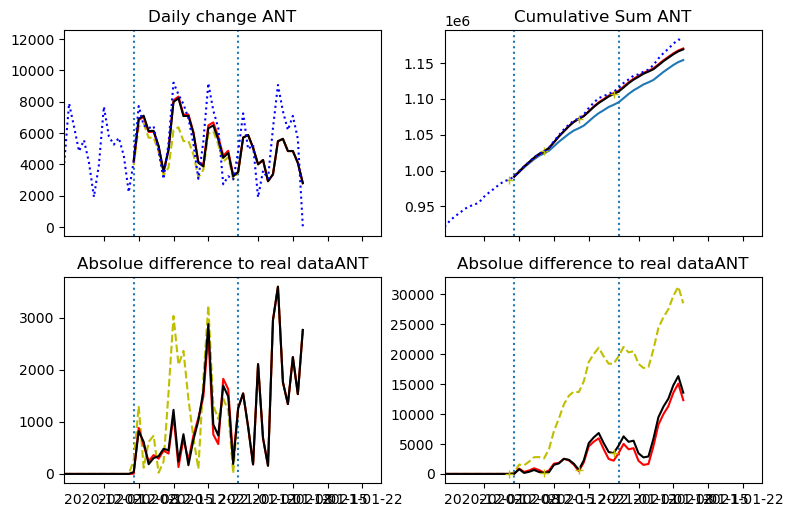

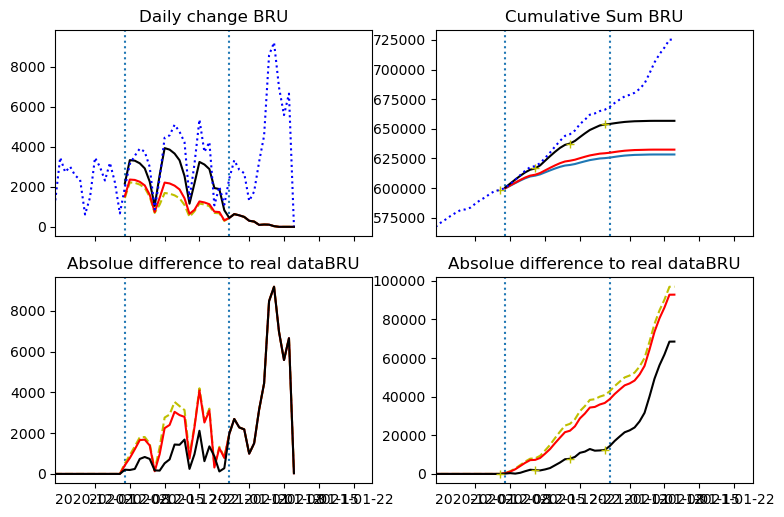

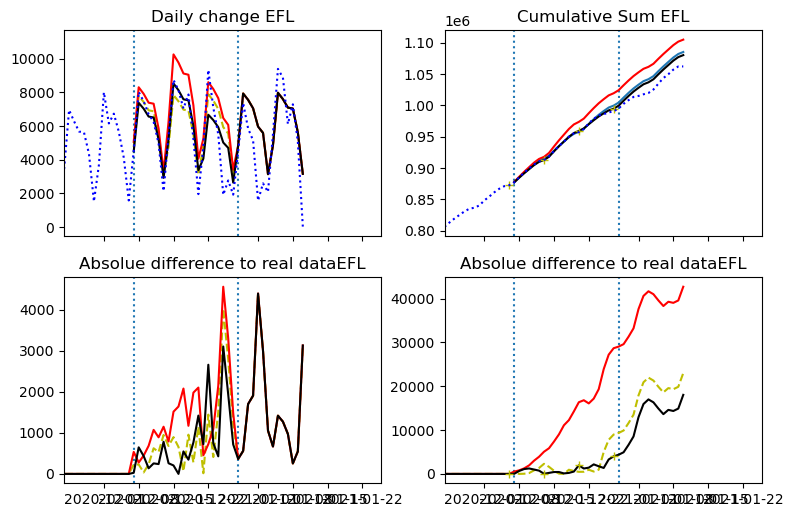

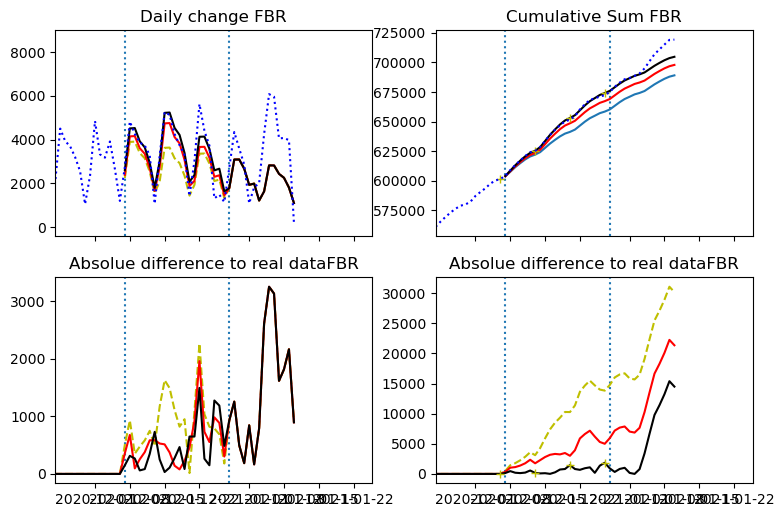

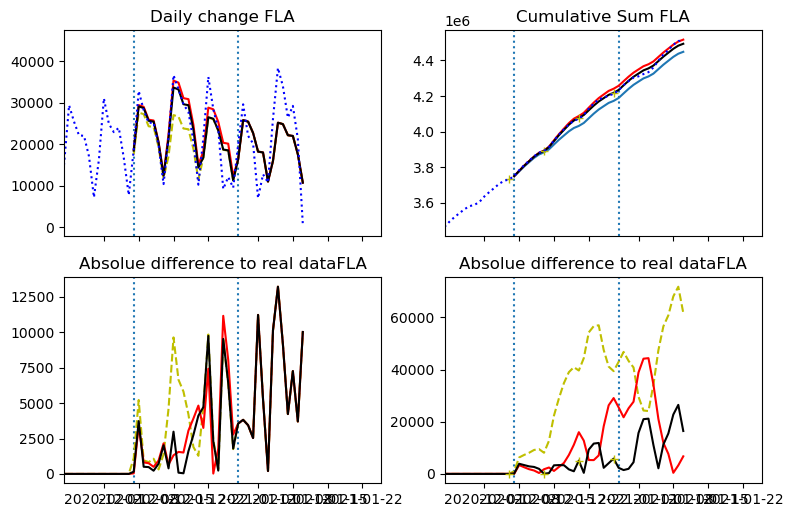

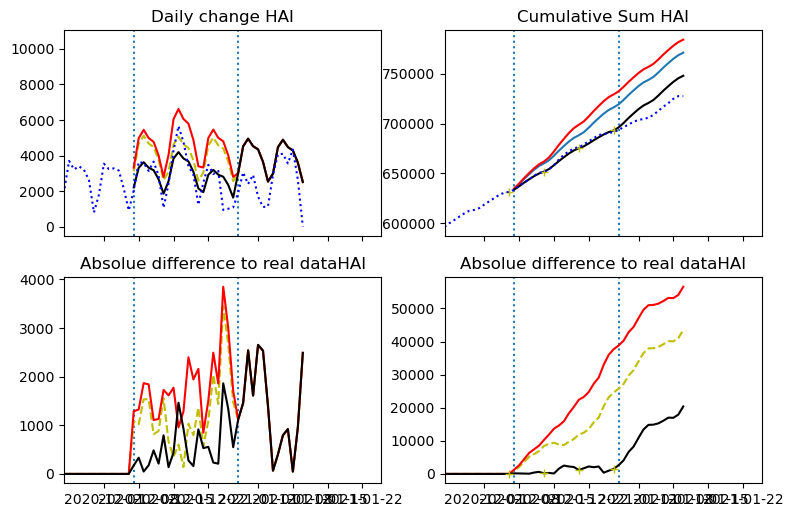

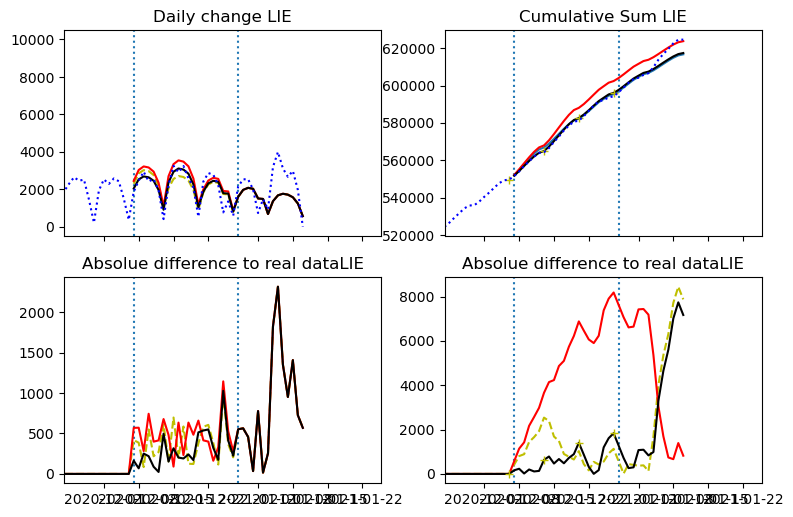

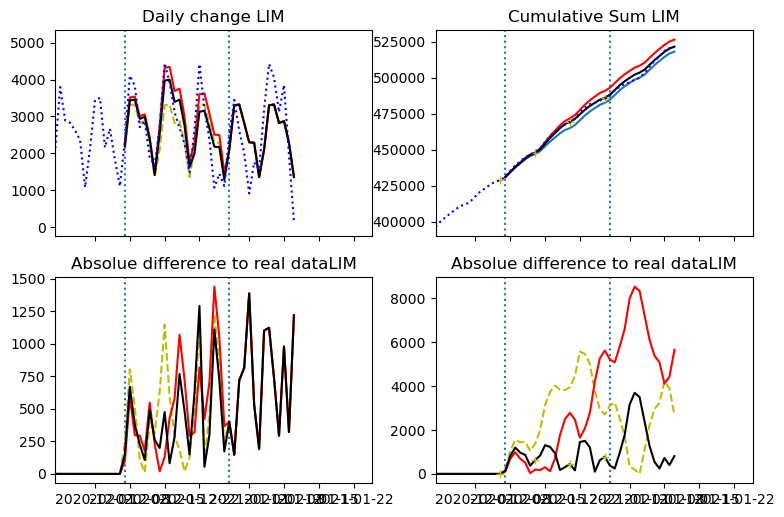

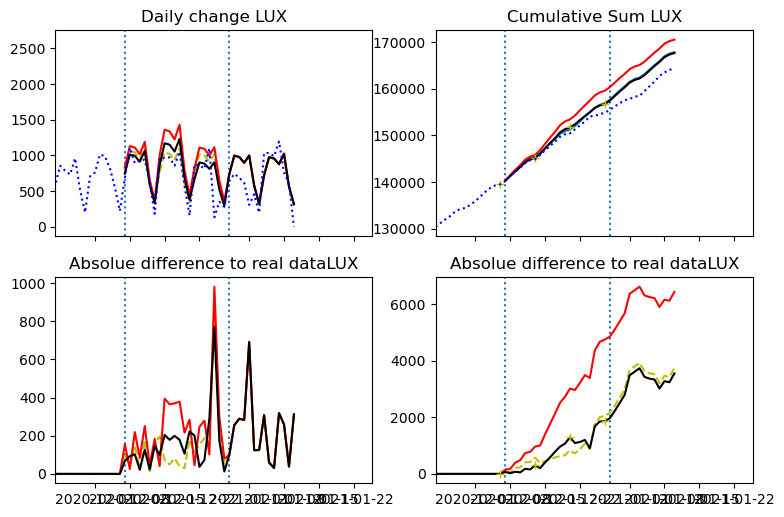

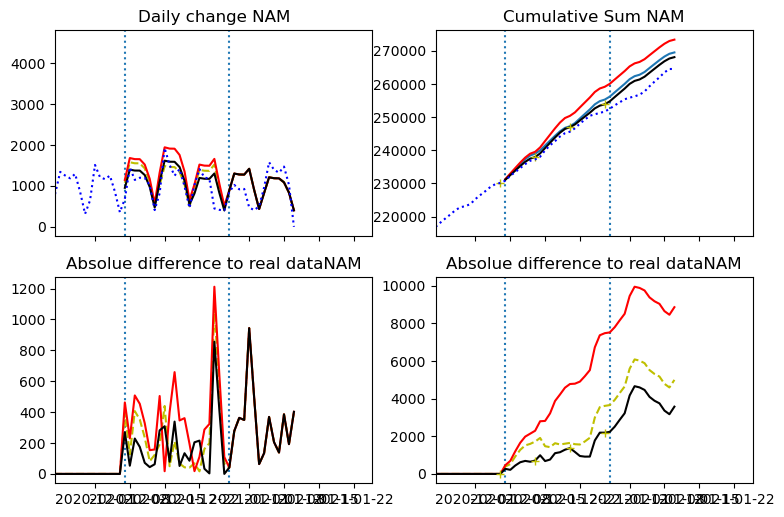

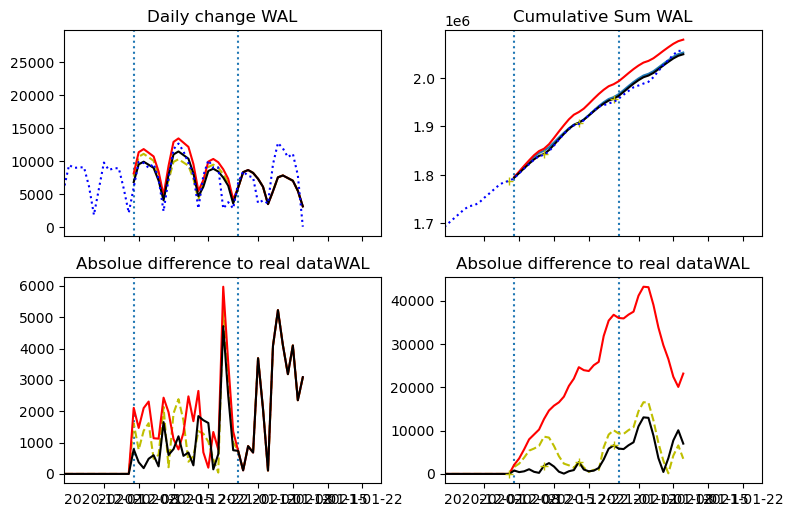

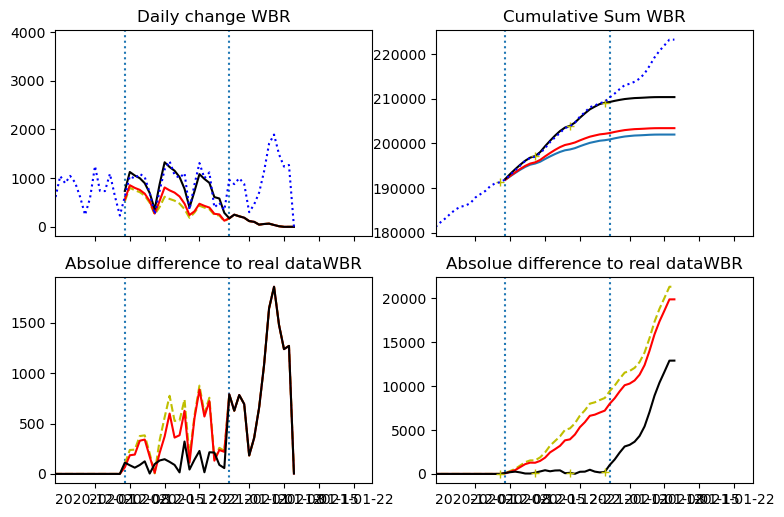

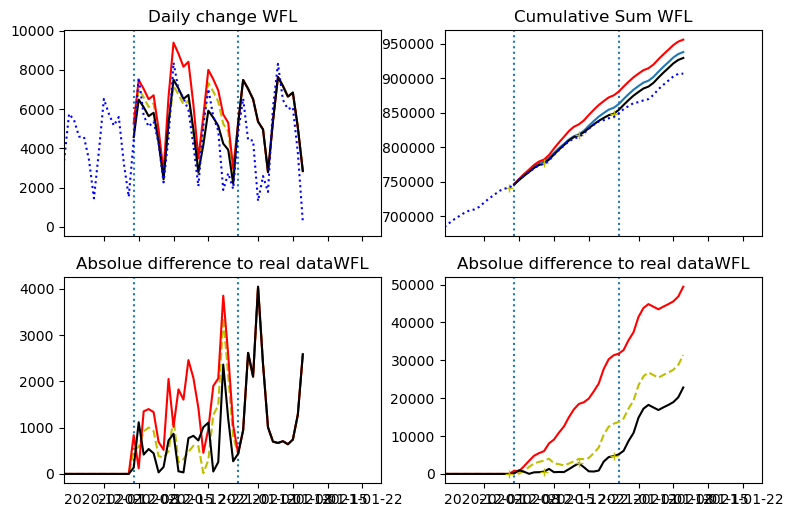

In [28]:
for region in non_all_regions:
    plot_corrected(region, corrected_for[region], corrected_for2[region], region_report_for[region])